In [182]:
%matplotlib inline
import sys
import collections
import numpy
from scipy.stats import gaussian_kde
import scipy.linalg

import matplotlib.pyplot as plt
import pickle


DO_NOT_PLOT = set([])
NUM_DATAPOINTS = 5000
MAX_MEMORY = 1015900 * 1024 # bytes
MAX_NETWORK = 10 # packets per second

with open('file_io.pickle.2', 'rb') as fp:
    cpu_stats = pickle.loads(fp.read())

In [183]:
def flatten(nested_dict):
    for k, v in nested_dict.items():
        if not isinstance(v, dict):
            yield k, v
        else:
            for _k, _v in flatten(v):
                yield ".".join([k, _k]), _v


def uninteresting(Y):
    if numpy.std(Y) < 10e-8:
        return True
    return False


def cast_ts_to_bin(ts, bin_size):
    return int(ts / bin_size) * bin_size


def add_stats(a, b):
    c = {'elements': a.get('elements', 0) + b.get('elements', 0) + 1}
    for k, v in a.items():
        if isinstance(v, dict):
            c[k] = add_stats(a.get(k, {}), b.get(k, {}))
        elif isinstance(v, (int, float, long)):
            c[k] = a.get(k, 0.) + b.get(k, 0.)
        elif not isinstance(v, (str, bytes, unicode)) and v is not None:
            continue # this prints a lot
    return c


def bin_stats(stats, ms_bin=1000):
    binned = collections.defaultdict(dict)
    for stat in stats:
        bin = cast_ts_to_bin(stat.get('t_ms'), ms_bin)
        binned[bin] = add_stats(stat, binned[bin])
        binned[bin]['t_ms'] = bin
    return sorted([b for b in binned.values()], key=lambda o: o.get('t_ms'))


def filter_overflows_from_columns(columns):
    indices_to_slice = set([])
    for label, column in columns.items():
        for i, value in enumerate(column):
            try:
                if value * value > sys.maxsize or (0 < value < 10e-9):
                    indices_to_slice.add(i)
            except Exception as e:
                break
    indices_to_slice = sorted(list(indices_to_slice), reverse=True) # hi to lo
    for label, column in columns.items():
        for index in indices_to_slice:
            column.pop(index)
    return columns, len(indices_to_slice)


def build_columns(binned_stats):
    columns = collections.defaultdict(list)
    for stat in binned_stats:
        for label, value in flatten(stat):
            columns[label].append(value)
    return {label: column[0:NUM_DATAPOINTS]
            for label, column in columns.items()
            if label != 't_ms'}

binned = bin_stats(cpu_stats[1:], ms_bin=10.)[0:NUM_DATAPOINTS]
print('using %i datapoints' % len(binned))

using 5000 datapoints


In [184]:
import json

import statsmodels.api as sm


def rlm(X, Y):
    exog = sm.add_constant(X.copy())
    endog = Y.copy()
    rlm_model = sm.RLM(endog, exog, M=sm.robust.norms.HuberT())
    rlm_results = rlm_model.fit()
    print('p', rlm_results.pvalues, 'chi', rlm_results.chisq, 'params', rlm_results.params)
    X = numpy.linspace(0, 12, 100)
    Y = rlm_results.predict(sm.add_constant(X))
    plt.plot(X, Y)

def plot_points(title, x_label, y_label, points, annotation=(0, 0)):
    font_size = 34
    plt.title(title, fontsize=font_size)
    plt.xlabel(x_label, fontsize=font_size)
    X, Y = points
    m, b, R, P, stderr = stats.linregress(X, Y)
    plt.ylabel('%s = %0.4f RPS + %0.2f' % (y_label, m, b), fontsize=font_size)
    xy = numpy.vstack([X, Y])
    try:
        Z = gaussian_kde(xy)(xy)
        plt.scatter(X, Y, c=Z, s=75, edgecolor='')
        rlm(X, Y)
        plt.plot(X, b + m*X, 'r', label='fitted line')
        plt.annotate('p=%0.2f, $r^2$=%0.2f' % ((P, R**2.)), annotation, fontsize=font_size)
        plt.colorbar()
    except scipy.linalg.LinAlgError as e:
        plt.scatter(X, Y)

network = []
memory = []
cpu = []
requests_per_second = []

for i in range(len(binned)-1):
    before = {label: value for label, value in flatten(binned[i])}
    after = {label: value for label, value in flatten(binned[i+1])}
    
    before = {k: v / float(before.get('elements')) for k, v in before.items()}
    after = {k: v / float(before.get('elements')) for k, v in after.items()}
    
    elapsed_time = (after.get('t_ms') - before.get('t_ms')) # ms
    assert after.get('client_requests.successful') > before.get('client_requests.successful'), "More requests before than after"
    rps = 1000. * (after.get('client_requests.successful') - before.get('client_requests.successful')) / elapsed_time
    if rps > 1000:
        continue
    #if rps < 1.5:
    #    continue
    
    idle_cpu_before = before.get('host.process.cpu.idle') - before.get('host.process.cpu.io_wait')
    total_cpu_before = before.get('host.process.cpu.total')
    idle_cpu_after = after.get('host.process.cpu.idle') - after.get('host.process.cpu.io_wait')
    total_cpu_after = after.get('host.process.cpu.total')
    expended_cpu = total_cpu_after - total_cpu_before
    if total_cpu_before == total_cpu_after: # We paused the script.
        continue
    if not total_cpu_before < total_cpu_after:
        print(json.dumps(before, indent=2, sort_keys=True)) 
        print(json.dumps(after, indent=2, sort_keys=True))
        raise AssertionError('cpu')
    used_cpu_percent = 1. - (idle_cpu_after - idle_cpu_before)/(total_cpu_after - total_cpu_before)    
    
    total_memory_before = before.get('host.memory.MemTotal:.value')
    free_memory_before = before.get('host.memory.MemFree:.value')
    if not free_memory_before < total_memory_before: 
        print(json.dumps(before, indent=2), json.dumps(after, indent=2))
    used_memory_percent = (total_memory_before - free_memory_before) / total_memory_before
    
    network_before = before.get('host.network.enp0s8.RX-OK')
    network_after = after.get('host.network.enp0s8.RX-OK')
    assert network_before < network_after, (json.dumps(before, indent=2), json.dumps(after, indent=2))
    network_percent = ((network_after - network_before) / elapsed_time) / MAX_NETWORK

    network.append(network_percent)
    requests_per_second.append(rps)
    cpu.append(used_cpu_percent)
    memory.append(used_memory_percent)

assert len(network) == len(requests_per_second)
assert len(requests_per_second) == len(cpu)
assert len(cpu) == len(memory)

requests_per_second = numpy.array(requests_per_second[0:NUM_DATAPOINTS])
cpu = numpy.array(cpu[0:NUM_DATAPOINTS])
memory = numpy.array(memory[0:NUM_DATAPOINTS])
network = numpy.array(network[0:NUM_DATAPOINTS])

assert len(network) == len(requests_per_second)
assert len(requests_per_second) == len(cpu)
assert len(cpu) == len(memory)


('p', array([0., 0.]), 'chi', array([6530.20768854, 8111.46350049]), 'params', array([0.05548941, 0.00740905]))
('p', array([0., 0.]), 'chi', array([7.12335054e+07, 7.55381025e+03]), 'params', array([0.87245723, 0.00107634]))
('p', array([1.54979696e-163, 0.00000000e+000]), 'chi', array([  742.70193109, 26009.62295657]), 'params', array([0.00131372, 0.00093138]))


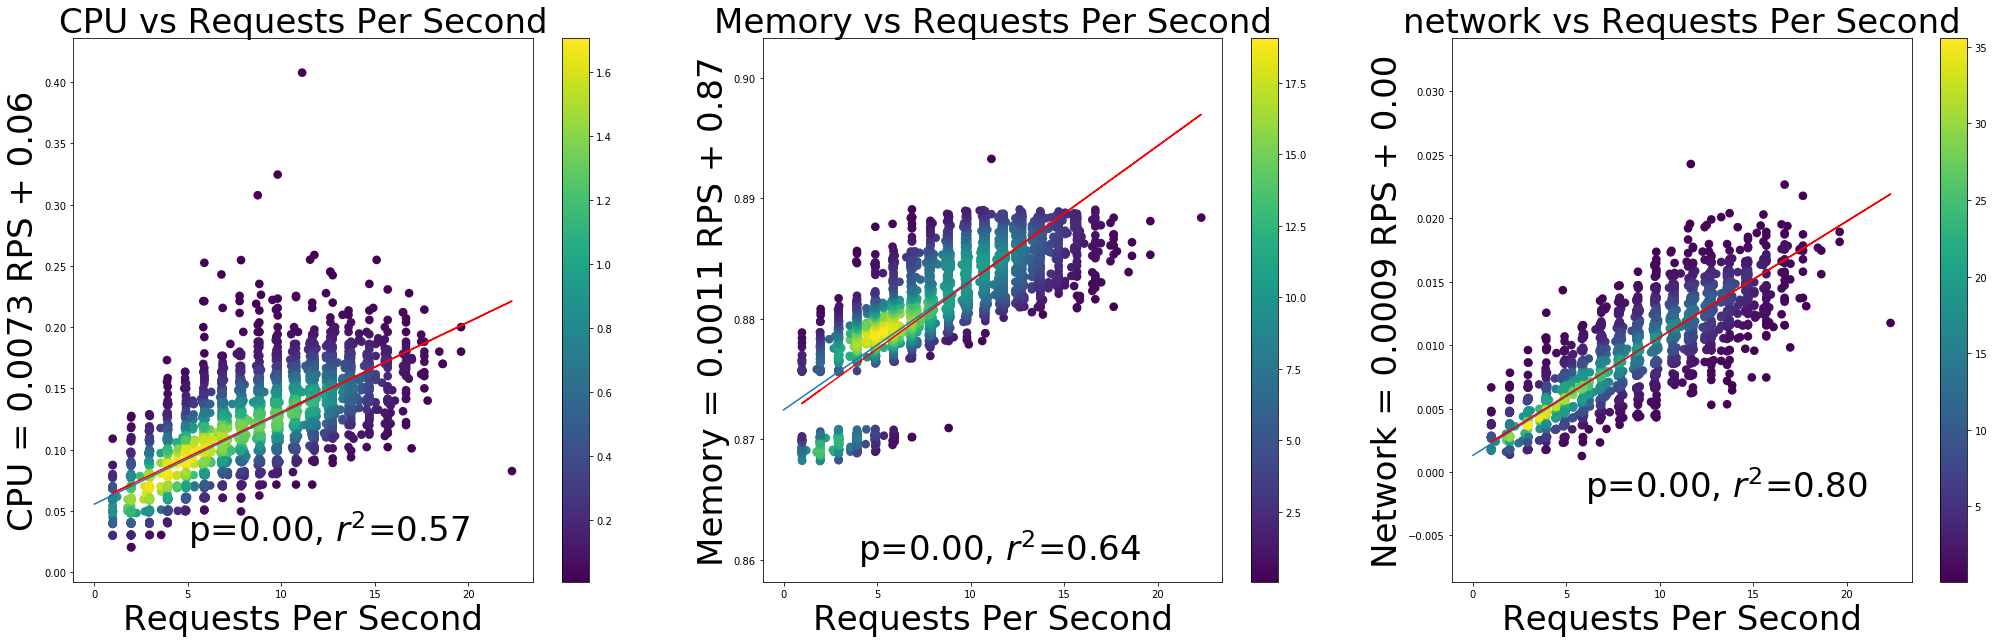

In [186]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(35,10))
plt.sca(axes[0])
plot_points("CPU vs Requests Per Second",
            "Requests Per Second",
            "CPU",
            (requests_per_second.copy(), cpu.copy()),
            (5, 0.025))

plt.sca(axes[1])
plot_points("Memory vs Requests Per Second",
            "Requests Per Second",
            "Memory",
            (requests_per_second.copy(), memory.copy()),
            (4, 0.86))

plt.sca(axes[2])
plot_points("network vs Requests Per Second",
            "Requests Per Second",
            "Network",
            (requests_per_second.copy(), network.copy()),
            (6, -0.002))
plt.show()

In [118]:
import statsmodels.api as sm

exog = requests_per_second.copy()
endog = cpu.copy()

rlm_model = sm.RLM(endog, exog, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
X = numpy.linspace(0, 12, 100)
Y = rlm_results.predict(X)
